[toc]

# ML 学习笔记-20-CART

## CART 理论部分

cart 树可以用来解决回归问题，也可以用来解决分类问题。

cart 树通过对节点的分裂来使用分裂准则减小，进而递归地生成树。值得一提的是 CART 树对于将每个节点都分为左节点和右节点。因此，CART 树生成的是一棵二叉树。

一棵 CART 树实际上对应的是对样本空间的一个划分。每个叶节点都对应都样本空间中的一块区域。设样本空间为 $R$，被 CART 树划分成为 m 个区域 $R_1, \cdots, R_m$，即 $R = \{R_1, \cdots, R_m\}$。

CART 树在每个节点都有一个输出值 $c_i$。因此，回归树可以表示为

$$
f(x) = \sum_{i=1}^{m} c_i I \{ x \in R_i \}
$$


- 对于分类问题，输出值 $c_i$ 为区域 $R_i$ 上的出现次数最多的类别，即 majority voting。
- 对于回归树，输出值 $c_i$ 为区域 $R_i$ 上的目标值的平均值，即 $c_i = average(y_i | x_i \in R_i)$。


### 结点的分裂

#### 结点划分的准则（损失函数）：

- 分类树：Gini index
- 回归树： mse

其中，Gini index 的计算如下：
对于一个二维离散分布，其分布列如下：

|x | $x_1$ | $x_2$ |
| -- | -- | -- | 
| p(X=x) | p | 1- p|

则其 Gini index 为

$$
Gini = p(1-p) = 1 - p^2
$$

对于一个多维离散分布，设其分布列为 


|x | $x_1$ | $x_2$ | $\cdots$ | $x_m$ |
| -- | -- | -- | -- | -- |
| p(X=x) | $p_1$ | $p_2$ | $\cdots$ | $p_m$ |

$$
Gini = \sum_{i=1}^m p_i(1-p_i) = \sum_{i=1}^m p_i - \sum_{i=1}^m p_i^2 = 1 - \sum_{i=1}^m p_i^2
$$

对于样本 $\{X_i, y_i\}^N_{i=1}$ 来说，设 $y_i$ 的取值有 k 类，分别是 $D_1, \cdots, D_k$，第 i 类 $D_i$ 有 $| D_i |$ 个样本，一共有 $|D|$ 个样本。则基于这个样本经验分布的 Gini index 为

$$
Gini = 1 - \sum_{i=1}^k \left(\frac{|D_i|}{|D|} \right)^2
$$

#### 如何根据分裂准则进行分裂？

CART采用递归二分分割的方法（每次一个区域分为两个子区域）来划分特征空间。描述如下：

选择第 j 个特征 x(j) 及它的取值 s ，把它们分别称为切分变量(splitting variable)和切点分(splitting point)。并定义两个区域：

$$
\begin{aligned}
R_1(j,s) &= \{x∣x(j)≤s\} \\ 
R_2(j,s) &= \{x∣x(j)>s\} 
\end{aligned}
$$

如何找到当前迭代中的最优切分变量 j 和最优切分点 s 呢？它们是下式（平方损失）达到最小值时对应的 j,s ：

$$
min_{j,s} \left[min_{c_1} \sum_{i \in R_1(j,s)} (y_i - c_1)  + min_{c_2} \sum_{i \in R_2(j,s)} (y_i - c_2) \right]
$$

#### 如何计算节点的输出值

可以看到，上面的式子中，有两层取 min 的操作。一个是外层的对 $(j,s)$ 取 min 的操作，一个是内层的 2 个 对 $c_1$ 和 $c_2$ 取 min 的操作。
其中内层的那个容易解出 
$$c_k = \frac{1}{|R_k|} \sum_{i \in R_k} y_i, k = 1, 2$$
即 $c_1$、$c_2$ 分别取均值时可以使用内层损失最小。由些得到对于回归问题，在节点的输出值为这个节点对应的区域中的样本目标值的平均值。

### 分裂停止的条件

1. 结点中的样本都属于一类（这个一般只有分类问题中会出现，回归问题中不会出现）
2. 损失函数的减小值小于阈值
3. 结点中的样本个数太少
4. 树到达规定深度

### CART 和 线性回归的区别

![](https://gitee.com/EdwardElric_1683260718/picture_bed/raw/master/img/20200706195230.png)

## 代码实现

### 结点的表示

我们要用什么数据结构来表示一棵树？ 一树棵由多个结点构成。那么结点又应该如何表示？
首先，一个结点上应该有下面一些信息

1. 这个结点分裂时的信息。根据那个特征分裂的？根据这个特征的哪个值分裂的？
2. 表示左右节点的引用。
3. 节点上的输出
4. 节点的深度

In [1]:
class TreeNode:
    def __init__(self, split_feat_idx =None,  split_feat_val=None, left=None, right=None, depth=None, output=None):
        self.split_feat_idx = split_feat_idx
        self.split_feat_val = split_feat_val
        self.output = output
        self.depth = depth
        self.left = left
        self.right = right
        
    # 定义一个 __str__ 便于 print
    def __str__(self):
        return f"""{{
            depth: {self.depth} output: {self.output} split_feat_idx: {self.split_feat_idx} split_feat_val: {self.split_feat_val}
            left: {self.left}
            right: {self.right}}}"""

### 树的构建

假设样本量为 n，特征个数为 p，
则我们的输入的 X 是一个 shape = (n, p) 的 np.ndarray，y 是一个 shape=(n, ) 的 np.ndarray

先定义一个 `splitData` 函数，输入是 split_feat_idx 和 split_val，表示根据 split_feat_idx 和 split_val 将数据集 X，y 分成两部分。

In [2]:
def splitData(X, y, split_idx, split_val):
    mask = X[:, split_idx] <= split_val
    left_X, right_X = X[mask], X[~mask]
    left_y, right_y = y[mask], y[~mask]
    return left_X, right_X, left_y, right_y

定义输出的计算和损失的计算。在 cart 树中，每个节点对应一个样本空间的一个区域。
- compute_pred 函数定义了如何计算这个区域上的输出值，对于回归问题，compute_output 输出的是这个区域上的样本的平均值
- compute_err 函数定义了如何根据数据集计算损失，对于回归问题，损失值是残差平方和。

In [3]:
def compute_pred(X, y):
    return np.mean(y)

def compute_err(X, y):
    return np.sum((y - compute_pred(X, y)) ** 2)

再定义一个寻找最优分裂特征的函数，输入数据集 X, y 返回分割的特征下标 best_feat_idx 和最优分割值 best_feat_val

In [4]:
def choose_best_feat(X, y):
    n_sample, n_feat = X.shape
    best_feat_idx = None
    best_feat_val = None
    best_err = float("inf")
    
    for i in range(n_feat): # 遍历所有特征
        x = X[:, i]
        for j in range(1, n_sample-1): # 遍历特征 i 的所有取值
            left_X, right_X, left_y, right_y = splitData(X, y, i, x[j])
            err = compute_err(left_X, left_y) + compute_err(right_X, right_y)
            if err < best_err:
                best_feat_idx = i
                best_feat_val = x[j]
                best_err = err
    return best_feat_idx, best_feat_val, best_err

In [5]:
# opt = { 
#     'max_depth': 8,
#     'min_err_decrease': 0.01,
#     "min_samples_split": 10 
# }

def create_tree(X, y, depth, opt):
    """
    根据 X，y 来创建树。
    """
    output = compute_pred(X, y)
    root = TreeNode(depth=depth, output=output)
    if X.shape[0] < opt["min_samples_split"] or depth >= opt["max_depth"]:
        return root

    split_feat_idx, split_feat_val, best_err = choose_best_feat(X, y)
        
    cur_err = compute_err(X, y)
    if cur_err - best_err < opt["min_err_decrease"]:
        return root
    root.split_feat_idx = split_feat_idx
    root.split_feat_val = split_feat_val
    
    # 递归调用
    left_X, right_X, left_y, right_y = splitData(X, y, split_feat_idx, split_feat_val)
    root.left = create_tree(left_X, left_y, depth=depth+1, opt=opt)
    root.right = create_tree(right_X, right_y, depth=depth+1, opt=opt)
    return root

In [6]:
import numpy as np

filename = "ex0.txt"
with open(filename) as f:
    data = [list(map(float, line.strip().split())) for line in f]
data = np.array(data)
X = data[:, 0][:, np.newaxis]
y = data[:, 1]

In [7]:
opt = { 
    'max_depth': 8,
    'min_err_decrease': 0.01,
    "min_samples_split": 10 
}

tree = create_tree(X, y, 0, opt)

/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/tensorflow2/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
print(tree)

{
            depth: 0 output: 2.00369868 split_feat_idx: 0 split_feat_val: 0.39435
            left: {
            depth: 1 output: 0.39728045333333334 split_feat_idx: 0 split_feat_val: 0.197834
            left: {
            depth: 2 output: -0.023838155555555553 split_feat_idx: 0 split_feat_val: 0.148654
            left: {
            depth: 3 output: -0.054810500000000005 split_feat_idx: 0 split_feat_val: 0.143143
            left: {
            depth: 4 output: -0.040866062499999994 split_feat_idx: 0 split_feat_val: 0.004327
            left: {
            depth: 5 output: 0.188975 split_feat_idx: None split_feat_val: None
            left: None
            right: None}
            right: {
            depth: 5 output: -0.04828029032258066 split_feat_idx: 0 split_feat_val: 0.052031
            left: {
            depth: 6 output: -0.1233381 split_feat_idx: 0 split_feat_val: 0.04127
            left: {
            depth: 7 output: -0.0663715 split_feat_idx: None split_feat_val: N

### 预测

先定义对于一个样本的预测

In [9]:
def _predict(node, x):
    if not node.left and not node.right:
        return node.output
    else:
        if x[node.split_feat_idx] <= node.split_feat_val:
            return _predict(node.left, x)
        else:
            return _predict(node.right, x)

再变成 batch 版本的

In [10]:
def predict(node, X):
    y = np.array([_predict(node, x) for x in X])
    return y

对测试集进行预测

In [11]:
yhat = predict(tree, X)

输出图像查看结果，可以看到拟合的效果不错

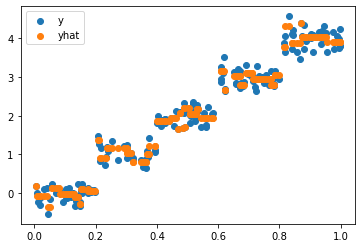

In [12]:
from matplotlib import pyplot as plt

plt.scatter(X.squeeze(), y, label='y')
plt.scatter(X.squeeze(), yhat.squeeze(), label='yhat')
plt.legend()
plt.show()

# References
1. [机器学习算法实践-树回归 | PytLab](http://pytlab.github.io/2017/11/03/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E7%AE%97%E6%B3%95%E5%AE%9E%E8%B7%B5-%E6%A0%91%E5%9B%9E%E5%BD%92/)